## Regularisation 

This is to reduce overfit. 

### l1 and l2 regularisation
This is the same as linear models. l2 to constrain connecting weights (recall it is sum of the weights squared with a coefficient alpha). Use l1 If you want a sparse model (many connecting weights to be 0), recall that l1 regularisation tends to make the weights of less important features to 0.


In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_valid, y_train,  y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.25)

print(X_train.shape, y_train.shape)

(45000, 28, 28) (45000,)


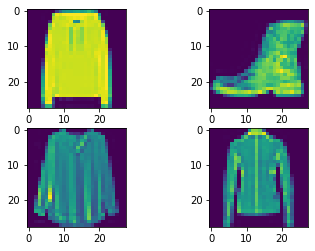

In [3]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(X_train[0])
ax[0][1].imshow(X_train[1])
ax[1][0].imshow(X_train[2])
ax[1][1].imshow(X_train[3])

In [16]:
from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam, Nadam, Adamax
from tensorflow import keras

# regularisers
# l1 tends to generate sparse models (mostly zeros), which saves memory and will run very fast at runtime
from tensorflow.keras.regularizers import l1, l2, l1_l2

es_cb = EarlyStopping(patience=3, monitor='val_loss') # early stopping at min loss
md_cb = ModelCheckpoint("f_mnist_model_A.h5", save_best_only=True) # setup a model check point

## Refactor layers using partial functions

As when we generate a ANN, we typically will use same activation, initialisers and regularisers. It makes sesne for us to reduce code clutter and improve readability by refactor it. 

In [15]:
from functools import partial

NomralDense = partial(Dense, activation = 'selu', 
                           kernel_initializer = keras.initializers.LecunNormal())

RegularisedDense1 = partial(Dense, activation = 'selu', 
                           kernel_initializer = keras.initializers.LecunNormal(), 
                           kernel_regularizer = l1(0.01))

RegularisedDense2 = partial(Dense, activation = 'selu', 
                           kernel_initializer = keras.initializers.LecunNormal(), 
                           kernel_regularizer = l2(0.01))


## Dropouts

*Dropout* is one of the most popular regularisation methods for deep neural networks. typically getting a 1-2% accuracy boost simply by add dropouts (consider if DNN is 95%) 1-2% of that is easily 20-30% imporovement.

At every training step, every neual (including the iutput neurons, excluding output neurons) has a probability *p* of being temorarily dropped out. (entirely ignored in the training for **this step**)

*p* is called the *drop rate* and typically set between 10% and 50%:
- ~20-30% in recurrent neural networks
- ~40-50% in convolutional neural networks.

After training, neuron is no longer being dropped.

As the input neurons can are dropped by *p*, when after training we need to compensate their weights by the *keep probability* (1-*p*)

In [17]:
model_normal = Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    NomralDense(300),
    BatchNormalization(),
    NomralDense(300),
    BatchNormalization(),
    NomralDense(300),
    BatchNormalization(),
    NomralDense(300),
    BatchNormalization(),
    Dense(10, activation = "softmax")
])

model_normal_drop_out = Sequential([
    Flatten(input_shape=[28, 28]),
    Dropout(rate = 0.2),
    BatchNormalization(),
    NomralDense(300),
    Dropout(rate = 0.2),
    BatchNormalization(),
    NomralDense(300),
    Dropout(rate = 0.2),
    BatchNormalization(),
    NomralDense(300),
    Dropout(rate = 0.2),
    BatchNormalization(),
    NomralDense(300),
    Dropout(rate = 0.2),
    BatchNormalization(),
    Dense(10, activation = "softmax")
])


model_l1 = Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    RegularisedDense1(300),
    BatchNormalization(),
    RegularisedDense1(300),
    BatchNormalization(),
    RegularisedDense1(300),
    BatchNormalization(),
    RegularisedDense1(300),
    BatchNormalization(),
    Dense(10, activation = "softmax")
])


model_l2 = Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    RegularisedDense2(300),
    BatchNormalization(),
    RegularisedDense2(300),
    BatchNormalization(),
    RegularisedDense2(300),
    BatchNormalization(),
    RegularisedDense2(300),
    BatchNormalization(),
    Dense(10, activation = "softmax")
])

NUM_EPOCHS = 20

models = [model_normal, model_normal_drop_out, model_l1, model_l2]
hist = []


for m in models:
    m.compile(optimizer =  "adam", loss = "sparse_categorical_crossentropy", metrics = "accuracy")
    history = m.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data = (X_valid, y_valid), callbacks = [es_cb],
                        verbose = False)
    hist.append(history)
    print(m.evaluate(X_test, y_test))

313/313 [==============================] - 0s 1ms/step - loss: 0.3778 - accuracy: 0.8756
[0.37775880098342896, 0.8755999803543091]
313/313 [==============================] - 0s 1ms/step - loss: 0.3723 - accuracy: 0.8740
[0.37228235602378845, 0.8740000128746033]
313/313 [==============================] - 0s 1ms/step - loss: 1.3362 - accuracy: 0.8018
[1.3361895084381104, 0.801800012588501]
313/313 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.8277
[0.5678825974464417, 0.8277000188827515]


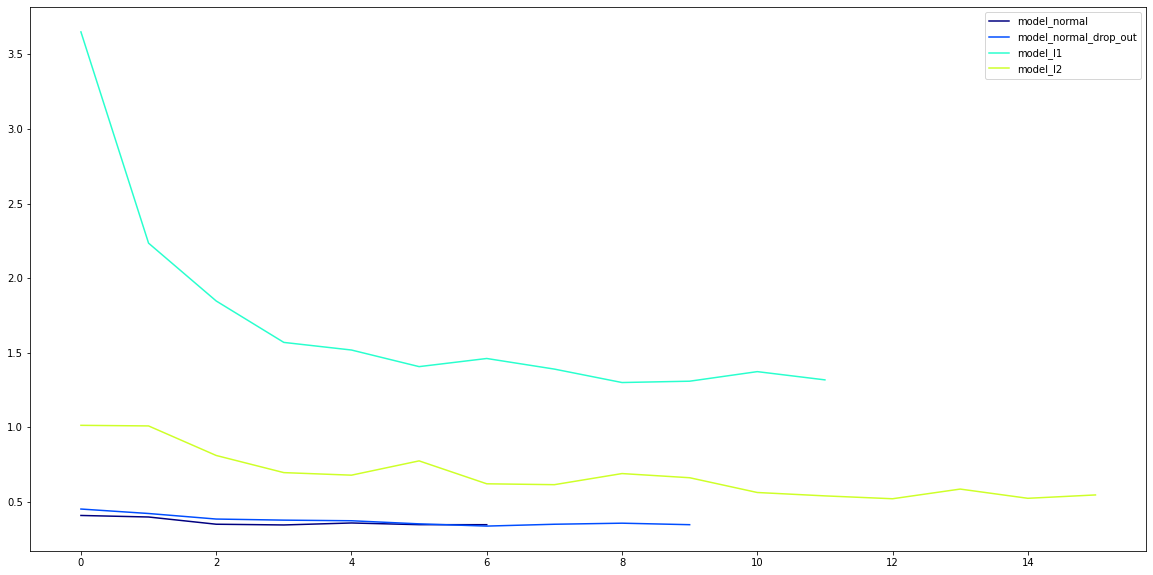

In [26]:
### Note that for drops the validation loss can be misleading as 
###the dropout is only active during the training phase

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


colors = cm.jet(np.linspace(0, 1, 6))
x1 = range(len(hist[0].history['val_loss']))
x2 = range(len(hist[1].history['val_loss']))
x3 = range(len(hist[2].history['val_loss']))
x4 = range(len(hist[3].history['val_loss']))

ax.plot(x1, hist[0].history['val_loss'], color = colors[0], label = "model_normal")
ax.plot(x2, hist[1].history['val_loss'], color = colors[1], label = "model_normal_drop_out")
ax.plot(x3, hist[2].history['val_loss'], color = colors[2], label = "model_l1")
ax.plot(x4, hist[3].history['val_loss'], color = colors[3], label = "model_l2")


ax.legend()
plt.show()

In [21]:
hist[0].history

{'loss': [0.5533322691917419,
  0.4258555471897125,
  0.3778979480266571,
  0.34806951880455017,
  0.3269388973712921,
  0.3099178671836853,
  0.28925013542175293],
 'accuracy': [0.8048444390296936,
  0.8466222286224365,
  0.8613333106040955,
  0.8722444176673889,
  0.8795777559280396,
  0.8835999965667725,
  0.8923777937889099],
 'val_loss': [0.4092400074005127,
  0.3989560604095459,
  0.35048148036003113,
  0.34557631611824036,
  0.3588271737098694,
  0.347526878118515,
  0.3473488688468933],
 'val_accuracy': [0.8511999845504761,
  0.859333336353302,
  0.8742666840553284,
  0.8760666847229004,
  0.8726000189781189,
  0.8785333037376404,
  0.8820666670799255]}

### Version Control

In [14]:
!git add 8_regularisation.ipynb
!git commit -m "added regularisation"
!git push

The file will have its original line endings in your working directory


[master 9634d9a] added regularisation
 1 file changed, 318 insertions(+), 291 deletions(-)
 rewrite tensorflow/8_regularisation.ipynb (74%)


To https://github.com/auslei/python.git
   4430f95..9634d9a  master -> master
